In [1]:
import torch
import random
from torch import nn
from torch.nn import MSELoss
from torch.utils.data import DataLoader
import get_data as get_data
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
import model
from metrics import multiclass_acc
from tqdm import tqdm
import numpy as np
import pickle
from model import save_model
from transformers import  BertTokenizer
from sklearn.metrics import accuracy_score, f1_score

def to_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [2]:
test = load_pickle('data/mosi_pro_test.pkl')
DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset= get_data.get_Dataset(test)
test_dataloader = DataLoader(test_dataset, batch_size=48, shuffle=True)
#test = get_data.convert_3_features(test,max_tlen=50,max_vlen=70,max_alen=80)
#test_dataloader = DataLoader(test, batch_size=48, shuffle=True)

1
2
3
4
5
6
7
=======OK!======


C:\Users\HeJH\Desktop\搞快点\实验部分\code\get_data.py:261: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  all_visual = torch.tensor([f.visual for f in aoli], dtype=torch.float)


In [3]:
word_size = 50
w_len = 50
v_len = 70
a_len = 80

hidden_size = 768
max_position = 150
modal_size = 3
layer_norm_eps = 1e-05
hidden_dropout_prob = 0.1 #0.125
word_embedding_dim = 768
visual_dim = 20 #20 35
audio_dim = 5   #5  74
attention_dropout_prob = 0.1 #0.125
num_head = 8
output_attention = 0
num_layer = 3
output_hidden_state = 0
intermediate_size = 768*2
num_head_modal = 8
num_layer_modal = 0


config = {'word_size': word_size , 'hidden_size': hidden_size , 'max_position': max_position ,
          'word_embedding_dim':word_embedding_dim, 'audio_dim':audio_dim,'visual_dim':visual_dim,
          'modal_size': modal_size , 'layer_norm_eps': layer_norm_eps , 'hidden_dropout_prob': hidden_dropout_prob ,
          'attention_dropout_prob':attention_dropout_prob , 'num_head':num_head , 'output_attention':output_attention,
          'num_layer':num_layer , 'output_hidden_state':output_hidden_state, 'intermediate_size':intermediate_size,
          'num_head_modal':num_head_modal,'num_layer_modal':num_layer_modal,'w_len':w_len,'v_len':v_len,'a_len':a_len}

TF_model = model.My_model(config).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
params = list(TF_model.named_parameters())

In [17]:
params[3][1].shape

torch.Size([70, 768])

In [4]:
# load the best weight
model = TF_model
#model.load_state_dict(torch.load('./weights/xf_model.pt')['state_dict'],map_location='cuda:0')
loaded_state = torch.load('./weights/version_2/excl_3_mosi_model.pt', map_location='cuda:0')
model.load_state_dict(loaded_state['state_dict'],False)


<All keys matched successfully>

In [5]:
model.state_dict()['transformer.Layer.0.attention.w_a'],model.state_dict()['transformer.Layer.1.attention.w_a'],model.state_dict()['transformer.Layer.2.attention.w_a']

(tensor(0.3095, device='cuda:0'),
 tensor(0.3430, device='cuda:0'),
 tensor(0.2562, device='cuda:0'))

In [14]:
model.state_dict()['transformer.Layer.0.attention.w_b'],model.state_dict()['transformer.Layer.1.attention.w_b'],model.state_dict()['transformer.Layer.2.attention.w_b']

(tensor(0.3017, device='cuda:0'),
 tensor(0.2949, device='cuda:0'),
 tensor(0.2774, device='cuda:0'))

In [15]:
model.state_dict()['transformer.Layer.0.attention.w_c'],model.state_dict()['transformer.Layer.1.attention.w_c'],model.state_dict()['transformer.Layer.2.attention.w_c']

(tensor(0.3008, device='cuda:0'),
 tensor(0.2970, device='cuda:0'),
 tensor(0.2859, device='cuda:0'))

In [6]:
def test_epoch(model: nn.Module, test_dataloader: DataLoader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_ids, input_mask, my_mask, segment_ids, visual_embedding, audio_embedding, label_ids = batch
            input_ids = torch.squeeze(input_ids, 1)
            #tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids))
            input_mask = torch.squeeze(input_mask, 1)
            my_mask = torch.squeeze(my_mask, 1)
            segment_ids = torch.squeeze(segment_ids, 1)
            visual_embedding = torch.squeeze(visual_embedding, 1)
            audio_embedding = torch.squeeze(audio_embedding, 1)
            outputs = model(
                input_ids,
                input_mask,
                my_mask,
                segment_ids,
                visual_embedding,
                audio_embedding
            )

            logits = outputs

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label_ids = np.squeeze(label_ids).tolist()

            preds.extend(logits)
            labels.extend(label_ids)

        preds = np.array(preds)
        labels = np.array(labels)

    return preds, labels


def test_score_model(model: nn.Module, test_dataloader: DataLoader, use_zero=False):

    preds, y_test = test_epoch(model, test_dataloader)
    non_zeros = np.array(
        [i for i, e in enumerate(y_test) if e != 0 or use_zero])

    preds = preds[non_zeros]
    y_test = y_test[non_zeros]

    test_preds_a7 = np.clip(preds, a_min=-3., a_max=3.)
    test_truth_a7 = np.clip(y_test, a_min=-3., a_max=3.)
    mult_a7 = multiclass_acc(test_preds_a7, test_truth_a7)

    mae = np.mean(np.absolute(preds - y_test))
    corr = np.corrcoef(preds, y_test)[0][1]

    preds = preds >= 0
    y_test = y_test >= 0

    f_score = f1_score(y_test, preds, average="weighted")
    acc = accuracy_score(y_test, preds)
    return acc, mae, corr, f_score,mult_a7

In [10]:
def test_epoch(model: nn.Module, test_dataloader: DataLoader):
    model.eval()
    preds = []
    labels = []
    tzs=[]

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_ids, input_mask, my_mask, segment_ids, visual_embedding, audio_embedding, label_ids = batch
            input_ids = torch.squeeze(input_ids, 1)
            input_mask = torch.squeeze(input_mask, 1)
            my_mask = torch.squeeze(my_mask, 1)
            segment_ids = torch.squeeze(segment_ids, 1)
            visual_embedding = torch.squeeze(visual_embedding, 1)
            audio_embedding = torch.squeeze(audio_embedding, 1)
            outputs,features = model(
                input_ids,
                input_mask,
                my_mask,
                segment_ids,
                visual_embedding,
                audio_embedding
            )

            logits = outputs
            tz=features.cpu().numpy()
            

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label_ids = np.squeeze(label_ids).tolist()

            preds.extend(logits)
            labels.extend(label_ids)
            tzs.extend(tz)

        preds = np.array(preds)
        labels = np.array(labels)
        tzs=np.array(tzs)

    return preds, labels,tzs

def test_score_model(model: nn.Module, test_dataloader: DataLoader, use_zero=False):

    preds, y_test,tz = test_epoch(model, test_dataloader)
    non_zeros = np.array(
        [i for i, e in enumerate(y_test) if e != 0 or use_zero])

    preds = preds[non_zeros]
    y_test = y_test[non_zeros]
    tz=tz[non_zeros,:]

    test_preds_a7 = np.clip(preds, a_min=-3., a_max=3.)
    test_truth_a7 = np.clip(y_test, a_min=-3., a_max=3.)
    mult_a7 = multiclass_acc(test_preds_a7, test_truth_a7)

    mae = np.mean(np.absolute(preds - y_test))
    corr = np.corrcoef(preds, y_test)[0][1]

    preds = preds >= 0
    y_test = y_test >= 0

    f_score = f1_score(y_test, preds, average="weighted")
    acc = accuracy_score(y_test, preds)
    return acc, mae, corr, f_score,mult_a7,tz,y_test

In [8]:
acc, mae, corr, f_score,mult_a7= test_score_model(TF_model, test_dataloader, False)
print("ACC:", acc)
print("MAE:", mae)
print("CORR:", corr)
print("F_SCORE:", f_score)
print("ACC7:",mult_a7)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.70it/s]

ACC: 0.8658536585365854
MAE: 0.7189127605826532
CORR: 0.7988340286966654
F_SCORE: 0.864567138619036
ACC7: 0.4634146341463415


In [32]:
tz.shape,y_test.shape

((656, 2304), (656,))

(1797, 64)


D:\Users\HeJH\Anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Users\HeJH\Anaconda3\envs\pytorch_gpu\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Users\HeJH\Anaconda3\envs\pytorch_gpu\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-6.7097497, -8.204296, '0'),
  Text(8.685368, 11.444996, '1'),
  Text(nan, nan, '2'),
  Text(nan, nan, '3'),
  Text(nan, nan, '4'),
  Text(nan, nan, '5'),
  Text(nan, nan, '6'),
  Text(nan, nan, '7'),
  Text(nan, nan, '8'),
  Text(nan, nan, '9')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


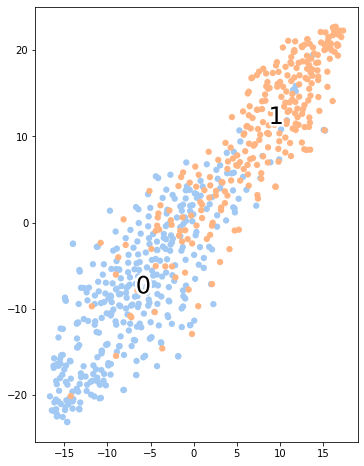

In [8]:
import numpy as np

from sklearn.manifold import TSNE
# For the UCI ML handwritten digits dataset
from sklearn.datasets import load_digits

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

def plot(x, colors):
    # Choosing color palette
    # https://seaborn.pydata.org/generated/seaborn.color_palette.html
    palette = np.array(sns.color_palette("pastel", 2))
    # pastel, husl, and so on

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int8)])
    # Add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    plt.savefig('./digits_tsne-pastel.png', dpi=120)
    return f, ax, txts


digits = load_digits()
print(digits.data.shape)
# There are 10 classes (0 to 9) with alomst 180 images in each class 
# The images are 8x8 and hence 64 pixels(dimensions)

# Place the arrays of data of each digit on top of each other and store in X
X = np.vstack([tz[y_test==i] for i in range(2)])
# Place the arrays of data of each target digit by the side of each other continuosly and store in Y
Y = np.hstack([y_test[y_test==i] for i in range(2)])

# Implementing the TSNE Function - ah Scikit learn makes it so easy!
digits_final = TSNE(n_components=2,perplexity=50,learning_rate=1000).fit_transform(X) 
# Play around with varying the parameters like perplexity, random_state to get different plots

plot(digits_final, Y)
